# Bringing tomography and pulses together

In [1]:
from qiskit import IBMQ
import qiskit.tools.jupyter
%qiskit_job_watcher

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend(open_pulse=True)

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [2]:
backend

/Users/thomassmith/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:355: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '
/Users/thomassmith/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:377: UserWarning: `rep_time` now has units of seconds(s) rather than microseconds(mu s).
  warnings.warn('`rep_time` now has units of seconds(s) rather '


<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>

## Process tomography for the Hadamard gate

In [ ]:
from qiskit.circuit import QuantumRegister, QuantumCircuit
from qiskit.ignis.verification.tomography import process_tomography_circuits
from qiskit.execute import execute

register = QuantumRegister(1)
circuit = QuantumCircuit(register)
circuit.h(0)

experiments = process_tomography_circuits(circuit, register[0])
job = execute(experiments, backend, shots=8000)
result = job.result()

print(job.job_id())

In [ ]:
from qiskit.ignis.verification.tomography import ProcessTomographyFitter
from qiskit.quantum_info import PTM
from qiskit.visualization import plot_state_hinton

tomography = ProcessTomographyFitter(result, experiments)
choi = tomography.fit()
ptm = PTM(choi)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_state_hinton(ptm.data.conjugate().transpose(), ax_real=ax)

ax.set_title(r'PTM');
ax.set_xticklabels(['I', 'X', 'Y', 'Z'])
ax.set_yticklabels(['I', 'X', 'Y', 'Z'])

print('CP? '+str(ptm.is_cp())+'.', 'TP? '+str(ptm.is_tp())+'.'n)

## Calculating the gate corrections

In [344]:
def to_ptm(op):
    ptm = np.zeros((4, 4), dtype=complex)
    for i in range(4):
        for j in range(4):
            ptm[i, j] = (paulis[i] * op * paulis[j] * op.dag()).tr()/2
    return qt.Qobj(ptm)

def rotation(theta, phi, lam):
    U = [[np.cos(theta/2), -np.exp(1j*lam) * np.sin(theta/2)], 
         [np.exp(1j*phi) * np.sin(theta/2), np.exp(1j*lam+1j*phi) * np.cos(theta/2)]]
    return qt.Qobj(U)

def ptm_norm(angles):
    theta_1, phi_1, lam_1 = angles[0:3] 
    theta_2, phi_2, lam_2 = angles[3:]
    U1 = to_ptm(rotation(theta_1, phi_1, lam_1))
    U2 = to_ptm(rotation(theta_2, phi_2, lam_2))
    n = qt.Qobj((ptm_ideal - U1 * qt.Qobj(ptm.data) * U2)[1:3][1:3]).norm()
    return n

In [346]:
H = qt.hadamard_transform()
ptm_ideal = to_ptm(H)

guess = np.zeros(6)
bound_pi = (0, np.pi)
bound_2pi = (0, 2*np.pi)
bounds = (bound_pi, bound_2pi, bound_2pi, bound_pi, bound_2pi, bound_2pi)

from scipy.optimize import minimize
solution = minimize(ptm_norm, guess, bounds=bounds)

In [347]:
theta1, phi1, lam1 = solution.x[0:3]
theta2, phi2, lam2 = solution.x[3:]

## Process tomography for the gate-"corrected" Hadamard gate

In [324]:
import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

register = QuantumRegister(1)
circuit_corr = QuantumCircuit(register)
circuit_corr.u3(theta1, phi1, lam1, 0)
circuit_corr.h(0)
circuit_corr.u3(theta2, phi2, lam2, 0)

experiments_corr = process_tomography_circuits(circuit_corr, register[0])
job_corr = execute(experiments_corr, backend, shots=8000)
result_corr = job_corr.result()

print(job_corr.job_id())

5e558264d180f200182220ed


CP? True. TP? False.


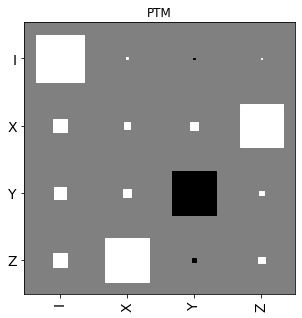

In [348]:
tomography_corr = ProcessTomographyFitter(result_corr, experiments_corr)
choi_corr = tomography_corr.fit()
ptm_corr = PTM(choi_corr)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_state_hinton(ptm_corr.data.conjugate().transpose(), ax_real=ax)

ax.set_title(r'PTM');
ax.set_xticklabels(['I', 'X', 'Y', 'Z'])
ax.set_yticklabels(['I', 'X', 'Y', 'Z'])

print('CP? '+str(ptm_corr.is_cp())+'.', 'TP? '+str(ptm_corr.is_tp())+'.')

## Checking native pulses

In [356]:
config = backend.configuration()
defaults = backend.defaults()
inst_sched_map = defaults.instruction_schedule_map
print(inst_sched_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'u1', 'u2', 'id', 'x', 'MEAS', 'u3', 'measure'}
Multi qubit instructions:
)>


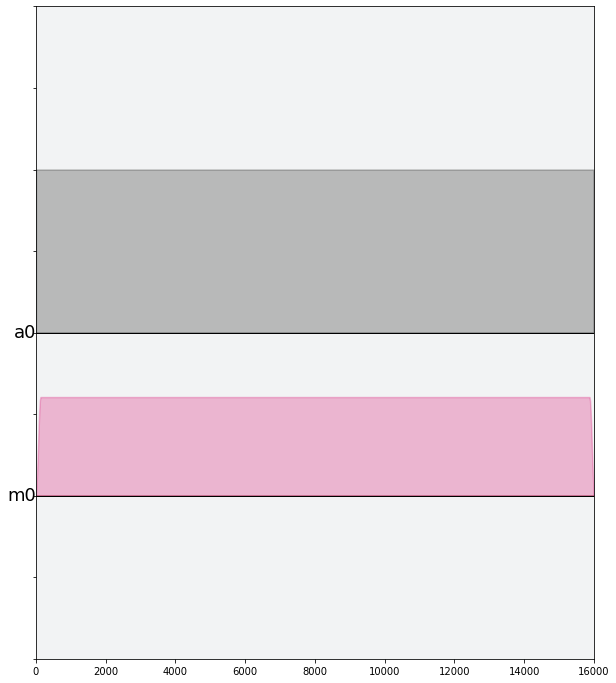

In [365]:
measure = inst_sched_map.get('measure', qubits=config.meas_map[0])
measure.draw()

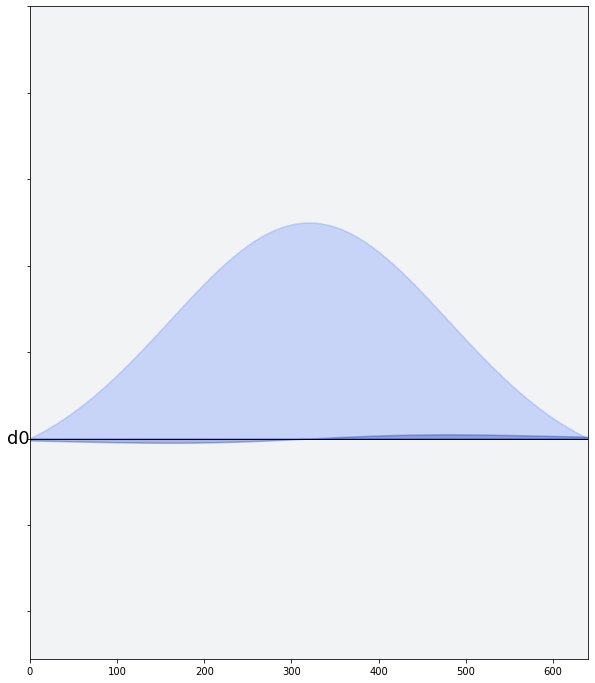

In [367]:
x = inst_sched_map.get('x', qubits=config.meas_map[0])
x.draw()

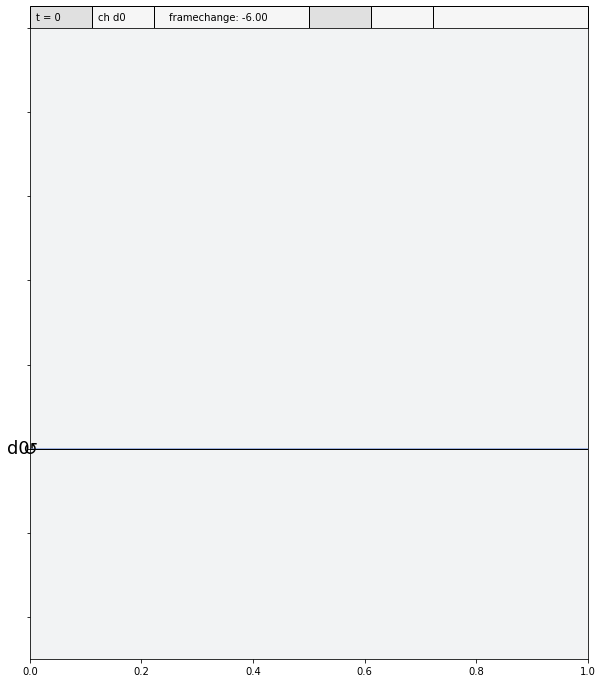

In [399]:
u1 = inst_sched_map.get('u1', 0, 6)
u1.draw()

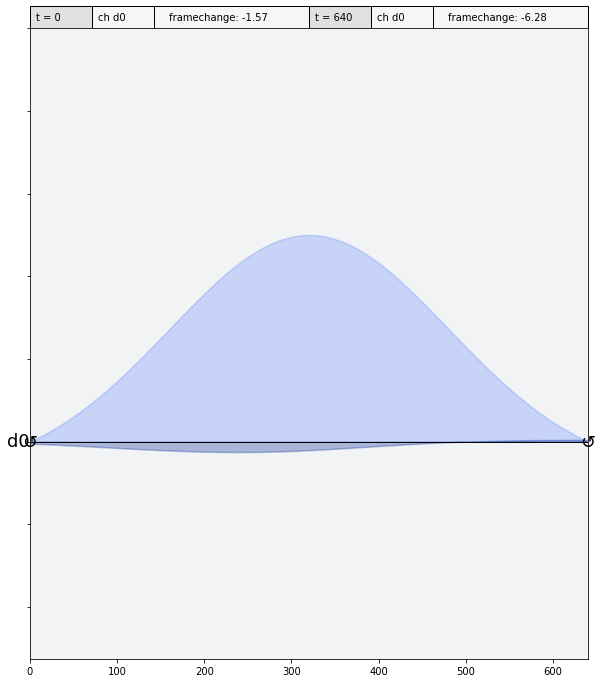

In [411]:
u2 = inst_sched_map.get('u2', 0, 2*np.pi, np.pi/2)
u2.draw()